<a href="https://colab.research.google.com/github/jhonda18/Python3/blob/main/Clase_5_20210515.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## La clase pasada

* Terminamos de ver Pandas
* Empezamos a ver la detección y tratamiento de datos missing.

Y hoy vamos a continuar con la detección y tratamiento de datos missing, y adicional, vamos a trabajar en la detección de datos atípicos y su tratamiento.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
diabetes = pd.read_csv("https://raw.githubusercontent.com/stivenlopezg/Modulo-Python-3/master/data/pima-indians-diabetes%20data.csv",
                       dtype={"Class": "category"})
diabetes.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1.0


In [ ]:
cols_to_drop = diabetes.columns[[True if i > 0.2 else False for i in diabetes.isna().mean().values.tolist()]]

diabetes = diabetes.drop(labels=cols_to_drop, axis=1)

In [ ]:
cols_to_drop

Index(['Skin_Fold', 'Serum_Insulin'], dtype='object')

In [ ]:
diabetes.isna().mean()

Pregnant             0.000000
Glucose              0.006510
Diastolic_BP         0.045573
BMI                  0.014323
Diabetes_Pedigree    0.000000
Age                  0.000000
Class                0.000000
dtype: float64

In [ ]:
# Funcion para ver la distribución antes y después de imputar

# def plot_imputations(dataframe: pd.DataFrame, column: str, method: str = "median", **kwargs):
#   plt.subplot(1, 2, 1)
#   sns.displot(data=dataframe, x=column, **kwargs)
#   plt.subplot(1, 2, 2)
#   if method == "median":
#     dataframe[column] = dataframe[column].fillna(dataframe[column].median())
#     sns.displot(data=dataframe, x=column, **kwargs)
#   elif method == "mean":
#     dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
#     sns.displot(data=dataframe, x=column, **kwargs)
#   else:
#     dataframe[column] = dataframe[column].fillna(dataframe[column].mode())
#     sns.displot(data=dataframe, x=column, **kwargs)
#   return plt.show()

In [ ]:
def plot_imputations(df: pd.DataFrame, column: str, method: str = 'median', **kwargs):
  plt.subplot(1, 2, 1)
  sns.distplot(df[column], **kwargs)
  plt.subplot(1, 2, 2)
  if method == 'median':
    sns.distplot(df[column].fillna(df[column].median()), **kwargs)
  elif method == 'mean':
    sns.distplot(df[column].fillna(df[column].mean()), **kwargs)
  else:
    sns.distplot(df[column].fillna(df[column].mode()), **kwargs)
  return plt.show()

In [ ]:
import warnings

warnings.filterwarnings(action="ignore")

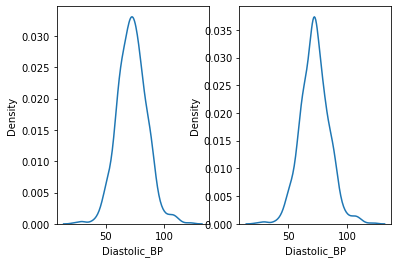

In [ ]:
aux = diabetes.copy()

plot_imputations(df=aux, column="Diastolic_BP", hist=False)

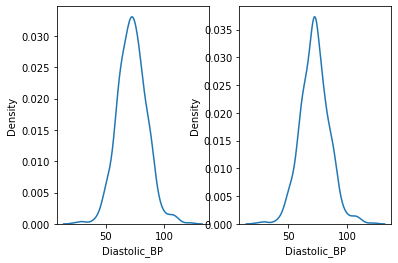

In [ ]:
plot_imputations(df=aux, column="Diastolic_BP", method="mean", hist=False)

In [ ]:
diabetes.isna().sum()

Pregnant              0
Glucose               5
Diastolic_BP         35
BMI                  11
Diabetes_Pedigree     0
Age                   0
Class                 0
dtype: int64

In [ ]:
aux.isna().sum()

Pregnant              0
Glucose               5
Diastolic_BP         35
BMI                  11
Diabetes_Pedigree     0
Age                   0
Class                 0
dtype: int64

In [ ]:
cols_to_impute = diabetes.columns[[True if col > 0 else False for col in diabetes.isna().sum().values.tolist()]]
cols_to_impute

Index(['Glucose', 'Diastolic_BP', 'BMI'], dtype='object')

In [ ]:
for col in cols_to_impute:
  diabetes[col] = diabetes[col].fillna(diabetes[col].median())

diabetes.isna().sum()

Pregnant             0
Glucose              0
Diastolic_BP         0
BMI                  0
Diabetes_Pedigree    0
Age                  0
Class                0
dtype: int64

## Diseño de Scikit-Learn
Estos son los principios de diseño más importantes:

* Consistencia: Todos los objetos comparten una interfaz simple y consistente:

  * Estimadores: Cualquier objeto que pueda estimar algunos parámetros basándose en un set de datos se llama "estimador" (por ejemplo, imputer es un estimador). La estimación en si la realiza el método **.fit()** y solo toma un conjunto de datos como parámetro (o dos para algoritmos de aprendizaje supervisado; el segundo set de datos contiene las etiquetas). Cualquier otro parámetro necesario para guiar el proceso de estimación se considera un hiperparámetro (como strategy de imputer) y debe establecerse como una variable de instancia (por lo general, mediante un parametro constructor).
  * Transformadores: Algunos estimadores (como imputer) también pueden transformar un conjunto de datos; se denominan transformadores. De nuevo, la API es sencilla: la transformación la lleva a cabo el método **.transform()** con el conjunto de datos para transformar como parámetro. Devuelve el conjunto de datos transformado. Esta transformación suele depender de los parámetros aprendidos, como es el caso de imputer.
  * Predictores: Por últimos, algunos estimadores, cuando se les da un conjunto de datos, son capaces de hacer predicciones; se llaman predictores. Por ejemplo, el modelo LinearRegression. Un predictor tiene un método **.predict()** que toma un conjunto de datos de observaciones nuevas y devuelve un conjunto de datos de predicciones correspondientes. También tiene un método .score() que mide la calidad de las predicciones correspondientes, dado un conjunto de prueba (y las etiquetas correspondientes, en el caso de algoritmos de aprendizaje supervisado).
* Inspección: Todos los hiperparámetros del estimador son accesibles de forma directa mediante variables de instancia públicas (por ejemplo, imputer.strategy) y todos los parámetros aprendidos del estimador son accesibles mediante variables de instancia pública con un guion bajo como sufijo (por ejemplo, imputer.statistics_).

* Composición: Los bloques de construcción existentes se reutilizan tanto como sea posible. Por ejemplo, es fácil crear un estimador Pipeline a partir de una secuencia de transformadores seguida de un estimador final, como veremos más adelante.


In [ ]:
class StandardScaler:
  def __init__(self, data: list):
    self.data = data
    self.mu = None
    self.sd = None

  def fit(self):
    self.mu = np.mean(self.data)
    self.sd = np.std(self.data)
    return self

  def transform(self):
    if self.mu is None:
      print("No se puede hacer la operacion, porque no se han calculado los parametros.")
    else:
      z = [(x - self.mu)/self.sd for x in self.data]
      return z

In [ ]:
datos = np.random.normal(loc=1000, scale=100, size=100).tolist()
datos[:10]

[1029.2807981310368,
 967.5030666327351,
 1079.9164176932488,
 1008.4996119123822,
 1106.5813932852343,
 853.1033662264878,
 1070.017913409,
 1190.7104511787895,
 927.8209771575529,
 1020.4081199758139]

In [ ]:
scaler = StandardScaler(data=datos)

In [ ]:
scaler.mu

In [ ]:
scaler.fit()

In [ ]:
print(f"La media de los datos es: {scaler.mu}")
print(f"La desviacion de los datos es: {scaler.sd}")

La media de los datos es: None
La desviacion de los datos es: None


In [ ]:
(datos[0] - scaler.mu)/scaler.sd

0.3657770453703107

In [ ]:
z = scaler.transform()
z[:10]

[0.3657770453703107,
 -0.31929688735470957,
 0.9272923711702905,
 0.1353275189111514,
 1.2229892064501735,
 -1.5879134383205937,
 0.8175245455535098,
 2.1559244753532276,
 -0.7593448534451537,
 0.2673849488950773]

In [ ]:
from sklearn.impute import SimpleImputer

* strategy (mean, median, most_frequent)

In [ ]:
aux.isna().sum()

Pregnant              0
Glucose               5
Diastolic_BP         35
BMI                  11
Diabetes_Pedigree     0
Age                   0
Class                 0
dtype: int64

In [ ]:
imputer = SimpleImputer(strategy='median')

In [ ]:
columns = aux.columns.tolist()
columns.pop()

'Class'

In [ ]:
imputer.fit(X=aux.loc[:, columns])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
for col, median in zip(columns, imputer.statistics_):
  print(f"Para la variable {col}, la mediana es: {median}")

Para la variable Pregnant, la mediana es: 3.0
Para la variable Glucose, la mediana es: 117.0
Para la variable Diastolic_BP, la mediana es: 72.0
Para la variable BMI, la mediana es: 32.3
Para la variable Diabetes_Pedigree, la mediana es: 0.3725
Para la variable Age, la mediana es: 29.0


In [ ]:
aux.loc[:, columns] = imputer.transform(aux[columns])

In [ ]:
aux.isna().sum()

Pregnant             0
Glucose              0
Diastolic_BP         0
BMI                  0
Diabetes_Pedigree    0
Age                  0
Class                0
dtype: int64

In [ ]:
import joblib

In [ ]:
joblib.dump(imputer, filename="imputer.joblib")

['imputer.joblib']

In [ ]:
imputer = None

In [ ]:
imputer.transform(aux[columns])

AttributeError: ignored

In [ ]:
imputer = joblib.load(filename="imputer.joblib")

In [ ]:
for col, median in zip(columns, imputer.statistics_):
  print(f"Para la variable {col}, la mediana es: {median}")

Para la variable Pregnant, la mediana es: 3.0
Para la variable Glucose, la mediana es: 117.0
Para la variable Diastolic_BP, la mediana es: 72.0
Para la variable BMI, la mediana es: 32.3
Para la variable Diabetes_Pedigree, la mediana es: 0.3725
Para la variable Age, la mediana es: 29.0


In [ ]:
aux.describe()

,Pregnant,Glucose,Diastolic_BP,BMI,Diabetes_Pedigree,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,32.455208,0.471876,33.240885
std,3.369578,30.438286,12.096642,6.875177,0.331329,11.760232
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,32.300000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000


In [ ]:
new_data = pd.DataFrame({'Pregnant': [3],
                         'Glucose': [45],
                         'Diastolic_BP': [np.nan],
                         'BMI': [27],
                         'Diabetes_Pedigree': [np.nan],
                         'Age': [28]})

new_data

,Pregnant,Glucose,Diastolic_BP,BMI,Diabetes_Pedigree,Age
0,3,45,NaN,27,NaN,28


In [ ]:
new_data = imputer.transform(new_data)
new_data

array([[ 3.    , 45.    , 72.    , 27.    ,  0.3725, 28.    ]])

## Imputación de datos de series de tiempo

Nuevamente el método **.fillna()** nos puede ayudar en las series de tiempo, sin embargo, hay otro método de Pandas que puede ser más preciso, este es **.interpolate()**.


In [ ]:
airquality = pd.read_csv("https://raw.githubusercontent.com/stivenlopezg/Modulo-Python-3/master/data/air-quality.csv",
                         parse_dates=["Date"])

airquality.head()

,Date,Ozone,Solar,Wind,Temp
0,1976-05-01,41.0,190.0,7.4,67
1,1976-05-02,36.0,118.0,8.0,72
2,1976-05-03,12.0,149.0,12.6,74
3,1976-05-04,18.0,313.0,11.5,62
4,1976-05-05,NaN,NaN,14.3,56


In [ ]:
airquality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    153 non-null    datetime64[ns]
 1   Ozone   116 non-null    float64       
 2   Solar   146 non-null    float64       
 3   Wind    153 non-null    float64       
 4   Temp    153 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 6.1 KB


In [ ]:
airquality[30:40]

,Date,Ozone,Solar,Wind,Temp
30,1976-05-31,37.0,279.0,7.4,76
31,1976-06-01,NaN,286.0,8.6,78
32,1976-06-02,NaN,287.0,9.7,74
33,1976-06-03,NaN,242.0,16.1,67
34,1976-06-04,NaN,186.0,9.2,84
35,1976-06-05,NaN,220.0,8.6,85
36,1976-06-06,NaN,264.0,14.3,79
37,1976-06-07,29.0,127.0,9.7,82
38,1976-06-08,NaN,273.0,6.9,87
39,1976-06-09,71.0,291.0,13.8,90


método **.fillna()** con el argumento *method*:

* ***bfill***
* ***ffill***

Hay otro método **.interpolate()** con el argumento *method*:

* ***linear***
* ***quadratic***
* ***nearest***

In [ ]:
bfill_imputed = airquality.fillna(method="bfill")

bfill_imputed[30:40]

,Date,Ozone,Solar,Wind,Temp
30,1976-05-31,37.0,279.0,7.4,76
31,1976-06-01,29.0,286.0,8.6,78
32,1976-06-02,29.0,287.0,9.7,74
33,1976-06-03,29.0,242.0,16.1,67
34,1976-06-04,29.0,186.0,9.2,84
35,1976-06-05,29.0,220.0,8.6,85
36,1976-06-06,29.0,264.0,14.3,79
37,1976-06-07,29.0,127.0,9.7,82
38,1976-06-08,71.0,273.0,6.9,87
39,1976-06-09,71.0,291.0,13.8,90


In [ ]:
ffill_imputed = airquality.fillna(method="ffill")

ffill_imputed[30:40]

,Date,Ozone,Solar,Wind,Temp
30,1976-05-31,37.0,279.0,7.4,76
31,1976-06-01,37.0,286.0,8.6,78
32,1976-06-02,37.0,287.0,9.7,74
33,1976-06-03,37.0,242.0,16.1,67
34,1976-06-04,37.0,186.0,9.2,84
35,1976-06-05,37.0,220.0,8.6,85
36,1976-06-06,37.0,264.0,14.3,79
37,1976-06-07,29.0,127.0,9.7,82
38,1976-06-08,29.0,273.0,6.9,87
39,1976-06-09,71.0,291.0,13.8,90


In [ ]:
linear_imputed = airquality.interpolate(method="linear")

linear_imputed[30:40]

,Date,Ozone,Solar,Wind,Temp
30,1976-05-31,37.000000,279.0,7.4,76
31,1976-06-01,35.857143,286.0,8.6,78
32,1976-06-02,34.714286,287.0,9.7,74
33,1976-06-03,33.571429,242.0,16.1,67
34,1976-06-04,32.428571,186.0,9.2,84
35,1976-06-05,31.285714,220.0,8.6,85
36,1976-06-06,30.142857,264.0,14.3,79
37,1976-06-07,29.000000,127.0,9.7,82
38,1976-06-08,50.000000,273.0,6.9,87
39,1976-06-09,71.000000,291.0,13.8,90


In [ ]:
linear_imputed.set_index("Date", inplace=True)
airquality.set_index("Date", inplace=True)

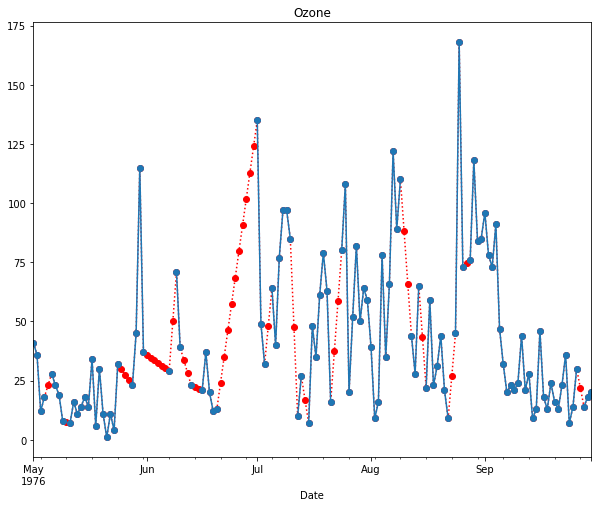

In [ ]:
linear_imputed["Ozone"].plot(color="red", marker="o", linestyle="dotted", figsize=(10, 8))
airquality["Ozone"].plot(title="Ozone", marker='o', figsize=(10, 8))
plt.show()

In [ ]:
airquality

,Ozone,Solar,Wind,Temp
Date,,,,
1976-05-01,41.0,190.0,7.4,67
1976-05-02,36.0,118.0,8.0,72
1976-05-03,12.0,149.0,12.6,74
1976-05-04,18.0,313.0,11.5,62
1976-05-05,NaN,NaN,14.3,56
...,...,...,...,...
1976-09-26,30.0,193.0,6.9,70
1976-09-27,NaN,145.0,13.2,77
1976-09-28,14.0,191.0,14.3,75
